<a href="https://colab.research.google.com/github/billzkhan/CNN_short_term_traffic_forecasting/blob/main/Bilal_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Install TensorFlow
try:
  %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# let's mount our own google drive instance
from google.colab import drive
drive.mount('/content/drive')

# Where to save the figures
sttf_folder = "/content/drive/My Drive/STTF Project"
PROJECT_ROOT_DIR = F"{sttf_folder}/Jupyter Notebooks/"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, transparent=True)

def plot_image(image, name=None, save=False):
  # different plots will be used based on the different representations
  colormap = "YlOrRd"
  if data_representation == 'color':
    vmin, vmax = 0, value_for_min_speed
  elif data_representation == 'speed':
    vmin, vmax = 0, max_speed
    colormap = "YlOrRd_r" # choose the reversed colormap for speed
  elif data_representation == 'density':
    vmin, vmax = 0, (max_speed / speed_limit)
    colormap = "YlOrRd_r" # choose the reversed colormap for density
  plt.imshow(image, cmap=colormap, interpolation="nearest", vmin=vmin, vmax=vmax)
  plt.axis("off")
  if save:
    save_fig(name)

def learning_curve(history, name, save=False):
  fig = pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  #plt.gca().set_ylim(0, 1)
  fig.set_title(F"Learning Curve for Model: {name}")
  plt.xlabel("Epochs")
  plt.ylabel("Loss / Accuracy")
  plt.gca()
  if save:
    save_fig(name + "_learning_curve")
  plt.show()

Unknown TensorFlow version: only exists in Colab.
Currently selected TF version: 1.x
Available versions:
 * 1.x
 * 2.x
TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Preprocessing

## Normalization

> Although differences exist, the model inputs are **normalized** to prevent model weights from increasing the model training difficulty. Second, the model outputs are different. In the context of transportation, the model outputs are **predicted traffic speeds on all road sections of a transportation network**, whereas, in the image classification problem, model outputs are image class labels. Third, abstract features have different meanings. In the context of transportation, abstract features extracted by the convolutional and pooling layers are relations among road sections regarding traffic speeds. In the image classification problem, the abstract features can be shallow image edges and deep shapes of some objects in terms of its training objective. All of these abstract features are significant for a prediction problem [36]. Fourth, the training objectives differ because of distinct model outputs. In the context of transportation, because the outputs are continuous traffic speeds, continuous cost functions should be adopted accordingly. In the image classification problem, cross-entropy cost functions are usually used.

Should take that into account! They have 236 links * 5 time steps * n classes for a fully connected output layer.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f07f4706c88>],
      dtype=object)

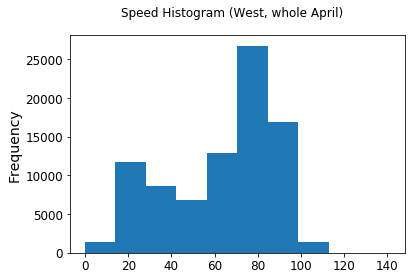

In [ ]:
# for normalization of the speed data, we need the maximum speed value for our test site
filename = "Highway_Speed_5Min.csv"
path = F"{sttf_folder}/Processed_Data/{filename}" 

# Store dataset in a Pandas Dataframe
df_processed = pd.read_csv(path, encoding='cp1252')

# our test site right now is test site 1, so we select only the linkids facing WEST
highway_west = df_processed[df_processed['LINKID'].isin([1230004400, 1230004600, 1220004500, 1220005500, 1220005600, 1210006400, 1210005300, 1210004900, 1210004500, 1210004400])]
highway_west['SPEED'].plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Speed Histogram (West, whole April)')

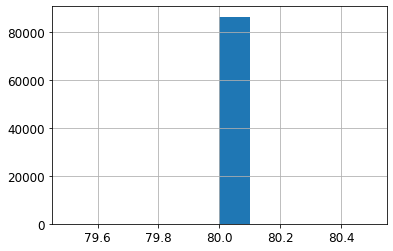

In [ ]:
highway_west['SPEEDLIMIT'].hist()

In [ ]:
# for normalization we need the min and max speed, as the values should be expressed in their range between min and max speed
# however, for simplicity, we will clip any speed values exceeding 1.5 * speedlimit, so as speedlimit is 80 km/h, we will clip at 120 km/h
min_speed = highway_west['SPEED'].min()
max_speed = 120
print("Min Speed: ", min_speed, "Max Speed: ", max_speed)

Min Speed:  0.0 Max Speed:  120


**The actual normalization will be done when we load the data, but we will use the values during normalization!**

**Normalization intuition**: the CNN should "learn from images" and pixels in images are represented via numerical values associated with their channels. In the paper, the authors use the color red to associate speed with, where 0 km/h is the strongest red value and 80 km/h is the least red value (i.e. white). We adapt this to our highway use case by choosing 1.5 * speedlimit (1.5 * 80 km/h = 120 km/h) as the maximum value with the least intensity of colour (i.e. white) and associate 0 km/h with the strongest congestion color (i.e. black). Color values are represented as [0:255], so in our case, 0 km/h will represent a color value of 255 and all speed measurements at 120 km/h or above will be represented as a 0 color value. Everything in between is linearly scaled.

In [ ]:
def color_normalize_data(df, min_speed, max_speed, max_color_value=255):
  # clip the values first between min_speed and max_speed
  df = df.clip(min_speed, max_speed)
  # normalize to [0:1]
  df = (df - min_speed) / (max_speed - min_speed);
  # reverse range because lowest speed is associated with highest color value
  df = 1 - df
  # scale to [0:max_color_value]
  df = df * max_color_value
  return df

def color_denormalize_data(arr, max_speed, max_color_value=255):
  # scale it back to [0:1]
  arr = arr / max_color_value
  # reverse order
  arr = 1 - arr
  # scale it back to max_speed
  arr = arr * max_speed
  return arr

# show an example, how the color normalization process works
df = pd.DataFrame([159, 0, 1, -1, 119, 50, 80])
norm_df = color_normalize_data(df, 0, 120, 255)
print(norm_df)
print(color_denormalize_data(norm_df.to_numpy(), 120, 255))

         0
0    0.000
1  255.000
2  252.875
3  255.000
4    2.125
5  148.750
6   85.000
[[120.]
 [  0.]
 [  1.]
 [  0.]
 [119.]
 [ 50.]
 [ 80.]]


## Data Exploration

In [ ]:
# load input data of study site 3

filename = "StudySite3_42"
path = F"{sttf_folder}/Input Data/StudySite3/{filename}.csv" 
df = pd.read_csv(path, index_col=1)

# remove unnamed column from the df
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,...,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289
V1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1220026200,30.99,29.38,29.74,29.32,30.54,32.27,27.98,31.19,30.97,30.48,28.43,31.22,30.58,28.39,29.94,30.12,30.03,26.61,30.61,28.59,29.47,33.45,34.04,28.73,30.89,33.30,41.00,29.22,33.00,30.52,28.94,30.25,33.71,33.64,30.20,36.81,30.71,52.00,33.80,32.18,...,23.58,22.77,22.98,22.35,23.57,24.43,23.31,22.81,26.00,24.72,22.21,25.51,24.13,24.56,22.46,24.52,24.62,24.11,24.27,24.13,22.43,26.02,24.91,22.52,24.88,24.40,21.64,25.40,23.98,25.84,24.21,24.00,24.06,25.16,23.66,25.10,27.23,28.14,24.80,23.77
1220022900,27.15,27.50,24.16,23.81,27.59,26.63,25.58,26.79,28.36,26.15,27.74,24.32,26.57,24.86,29.77,25.29,27.27,27.22,28.24,25.91,24.63,26.51,27.17,32.96,26.06,30.79,32.25,24.85,27.16,26.22,28.57,28.44,25.03,27.47,24.92,28.41,34.09,26.23,26.00,26.02,...,18.62,20.37,16.79,16.03,19.51,19.41,19.15,20.58,16.95,20.25,18.56,21.73,18.07,22.12,23.97,20.19,20.56,25.22,23.47,20.46,28.04,25.29,26.53,25.47,24.83,23.84,26.19,25.12,25.26,25.44,24.03,26.41,23.84,26.16,24.55,25.51,28.22,28.67,29.65,25.22
1220023000,34.78,34.92,36.10,31.41,30.73,26.61,31.21,27.12,35.70,26.20,28.14,26.91,25.35,28.33,21.22,24.33,29.35,30.82,28.20,35.64,38.40,30.39,28.18,35.55,29.25,37.94,33.19,29.31,33.29,37.01,36.54,30.56,31.63,30.83,30.13,30.44,33.83,25.00,30.09,35.76,...,21.72,20.30,21.72,22.69,20.66,21.42,29.05,20.75,23.94,21.25,21.46,24.11,22.61,20.89,21.53,21.93,22.25,23.91,21.33,22.68,21.98,19.48,21.07,22.23,21.63,17.97,22.66,20.93,20.81,20.62,21.12,21.13,22.14,22.09,22.62,22.34,21.18,22.79,21.40,24.79
1220026300,35.28,31.75,33.95,26.86,32.34,31.73,27.93,29.77,28.00,25.60,29.07,27.22,26.80,31.03,23.15,27.96,33.38,32.71,29.05,34.38,34.81,31.75,31.67,32.49,35.93,33.27,33.57,31.87,32.88,34.48,29.07,34.76,29.83,32.83,29.17,27.73,30.32,34.68,32.22,37.07,...,16.72,25.50,20.25,18.74,16.34,19.90,25.52,15.53,18.46,22.97,20.05,23.76,19.77,21.96,24.12,22.18,24.66,25.93,27.20,27.98,26.58,25.65,29.36,27.41,27.75,25.20,27.73,29.60,30.24,26.80,26.04,27.61,25.92,25.24,23.73,28.92,29.36,29.42,25.93,26.85
1220030800,33.12,30.42,28.38,28.07,26.42,26.66,23.96,30.28,25.92,24.77,32.00,27.12,26.38,28.83,25.84,31.68,30.15,26.98,28.43,24.60,30.70,31.98,24.97,32.34,32.50,31.93,35.93,39.63,28.02,29.18,34.62,32.87,43.50,40.00,42.00,28.99,30.89,35.50,32.51,31.54,...,18.41,22.86,18.32,19.27,19.15,19.58,19.06,19.71,17.81,15.27,19.19,20.70,16.13,20.63,21.23,24.00,18.03,26.50,20.82,25.54,20.68,18.89,22.31,28.01,26.08,27.02,20.80,24.98,26.66,23.18,27.59,22.90,31.37,27.56,28.75,31.17,25.61,33.45,26.79,31.32


In [ ]:
df.iloc[:, :12] # first twelve columns of data frame with all rows

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
V1,,,,,,,,,,,,
1220026200,30.99,29.38,29.74,29.32,30.54,32.27,27.98,31.19,30.97,30.48,28.43,31.22
1220022900,27.15,27.50,24.16,23.81,27.59,26.63,25.58,26.79,28.36,26.15,27.74,24.32
1220023000,34.78,34.92,36.10,31.41,30.73,26.61,31.21,27.12,35.70,26.20,28.14,26.91
1220026300,35.28,31.75,33.95,26.86,32.34,31.73,27.93,29.77,28.00,25.60,29.07,27.22
1220030800,33.12,30.42,28.38,28.07,26.42,26.66,23.96,30.28,25.92,24.77,32.00,27.12
1220030000,26.73,29.12,25.52,27.94,28.83,27.80,27.62,29.91,31.72,31.53,29.93,39.00
1220029000,22.96,23.33,25.28,23.37,23.57,22.96,23.54,23.75,21.61,25.48,22.64,19.76
1220028200,28.71,27.12,24.95,30.57,30.02,29.93,30.27,28.46,29.04,33.86,35.26,30.64
1220028300,23.29,23.78,20.97,28.63,20.97,23.65,26.27,25.23,22.19,29.20,27.42,27.11


In [ ]:
# sort a given dataframe by a linkid order dict
def sort_by_linkid(df, order):
  #return df.loc[df[col_name].map(sort_dict).sort_values().index]
  return df.reindex(order)

# create a dict from all the link ids with their index in the list
def get_sort_dict(order):
  return dict(zip(order, range(1, len(order) + 1)))

# all link ids:
all_link_ids = [1220028100, 1220022900, 1220023000, 1220026300, 1220030800, 1220030000, 1220029000, 1220028200, 1220028300, 1220029100, 1220030100, 1220030900, 1220029200, 1220026600, 1220026700, 
                1220029300, 1220027600, 1220025800, 1220025900, 1220027700, 1220027400, 1220024600, 1220024700, 1220027500, 1220022300, 1220023900, 1220025500, 1220026500, 1220026400, 1220025400, 
                1220023800, 1220022200, 1220003300, 1220003100, 1220003200, 1220003400, 1220028000, 1220026800, 1220026000, 1220025200, 1220025300, 1220026100, 1220026900, 1220026200]

             
sort_dict = get_sort_dict(all_link_ids)

df = sort_by_linkid(df, sort_dict)
df

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,...,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289
V1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1220028100,17.08,19.49,21.37,17.80,16.20,16.76,16.34,16.37,16.08,20.32,17.72,17.20,17.65,18.17,18.35,18.16,16.99,19.52,18.22,17.36,24.09,22.77,18.14,20.67,17.75,19.96,17.89,16.79,18.20,17.64,20.47,17.64,18.28,19.81,22.73,20.85,17.76,20.78,19.94,26.77,...,14.63,10.86,13.69,11.17,14.64,10.43,11.99,13.04,13.64,11.41,13.50,14.38,15.12,15.04,16.03,14.70,17.48,16.92,13.16,14.92,14.17,13.84,13.97,12.01,11.12,10.72,14.04,19.18,20.05,24.14,21.33,16.52,18.33,17.45,16.66,17.33,17.35,17.80,16.50,18.15
1220022900,27.15,27.50,24.16,23.81,27.59,26.63,25.58,26.79,28.36,26.15,27.74,24.32,26.57,24.86,29.77,25.29,27.27,27.22,28.24,25.91,24.63,26.51,27.17,32.96,26.06,30.79,32.25,24.85,27.16,26.22,28.57,28.44,25.03,27.47,24.92,28.41,34.09,26.23,26.00,26.02,...,18.62,20.37,16.79,16.03,19.51,19.41,19.15,20.58,16.95,20.25,18.56,21.73,18.07,22.12,23.97,20.19,20.56,25.22,23.47,20.46,28.04,25.29,26.53,25.47,24.83,23.84,26.19,25.12,25.26,25.44,24.03,26.41,23.84,26.16,24.55,25.51,28.22,28.67,29.65,25.22
1220023000,34.78,34.92,36.10,31.41,30.73,26.61,31.21,27.12,35.70,26.20,28.14,26.91,25.35,28.33,21.22,24.33,29.35,30.82,28.20,35.64,38.40,30.39,28.18,35.55,29.25,37.94,33.19,29.31,33.29,37.01,36.54,30.56,31.63,30.83,30.13,30.44,33.83,25.00,30.09,35.76,...,21.72,20.30,21.72,22.69,20.66,21.42,29.05,20.75,23.94,21.25,21.46,24.11,22.61,20.89,21.53,21.93,22.25,23.91,21.33,22.68,21.98,19.48,21.07,22.23,21.63,17.97,22.66,20.93,20.81,20.62,21.12,21.13,22.14,22.09,22.62,22.34,21.18,22.79,21.40,24.79
1220026300,35.28,31.75,33.95,26.86,32.34,31.73,27.93,29.77,28.00,25.60,29.07,27.22,26.80,31.03,23.15,27.96,33.38,32.71,29.05,34.38,34.81,31.75,31.67,32.49,35.93,33.27,33.57,31.87,32.88,34.48,29.07,34.76,29.83,32.83,29.17,27.73,30.32,34.68,32.22,37.07,...,16.72,25.50,20.25,18.74,16.34,19.90,25.52,15.53,18.46,22.97,20.05,23.76,19.77,21.96,24.12,22.18,24.66,25.93,27.20,27.98,26.58,25.65,29.36,27.41,27.75,25.20,27.73,29.60,30.24,26.80,26.04,27.61,25.92,25.24,23.73,28.92,29.36,29.42,25.93,26.85
1220030800,33.12,30.42,28.38,28.07,26.42,26.66,23.96,30.28,25.92,24.77,32.00,27.12,26.38,28.83,25.84,31.68,30.15,26.98,28.43,24.60,30.70,31.98,24.97,32.34,32.50,31.93,35.93,39.63,28.02,29.18,34.62,32.87,43.50,40.00,42.00,28.99,30.89,35.50,32.51,31.54,...,18.41,22.86,18.32,19.27,19.15,19.58,19.06,19.71,17.81,15.27,19.19,20.70,16.13,20.63,21.23,24.00,18.03,26.50,20.82,25.54,20.68,18.89,22.31,28.01,26.08,27.02,20.80,24.98,26.66,23.18,27.59,22.90,31.37,27.56,28.75,31.17,25.61,33.45,26.79,31.32
1220030000,26.73,29.12,25.52,27.94,28.83,27.80,27.62,29.91,31.72,31.53,29.93,39.00,30.15,31.98,26.40,33.00,30.38,29.83,29.94,24.28,30.53,31.38,26.47,33.00,27.60,28.19,29.89,30.31,38.00,39.00,31.47,29.62,30.78,35.00,31.92,31.10,31.55,36.00,29.41,32.91,...,23.31,24.49,23.85,24.04,25.11,23.41,23.12,22.03,24.57,23.75,23.24,23.54,22.65,24.95,24.00,22.52,21.48,22.41,23.03,22.42,23.68,25.92,22.17,25.22,25.25,28.31,24.35,24.29,24.93,24.22,26.20,24.60,26.05,24.98,23.83,26.68,24.68,27.60,27.48,27.50
1220029000,22.96,23.33,25.28,23.37,23.57,22.96,23.54,23.75,21.61,25.48,22.64,19.76,21.92,23.00,23.25,25.95,23.21,23.78,25.56,25.33,24.10,25.19,24.85,22.61,25.10,26.53,24.88,25.45,21.12,25.00,22.61,24.25,26.01,28.70,26.27,24.13,23.54,26.14,21.92,24.17,...,21.12,19.17,19.15,25.08,20.63,19.87,25.70,19.65,20.64,23.03,19.04,19.56,25.14,25.98,20.98,22.30,24.06,27.42,24.12,22.88,24.90,24.55,25.89,23.80,26.12,26.44,24.30,25.36,25.84,26.14,26.37,26.29,25.87,27.80,28.25,27.04,28.00,26.04,25.98,27.84
1220028200,28.71,27.12,24.95,30.57,30.02,29.93,30.27,28.46,29.04,33.86,35.26,30.64,24.77,28.28

In [ ]:
# we need to extract the different speed limits per linkid from the table
filename = "GangNamGu_Speed_5Min.csv"
path = F"{sttf_folder}/Processed_Data/{filename}" 

# Store dataset in a Pandas Dataframe
df_processed = pd.read_csv(path, encoding='cp1252')

# get all the link ids included in test site 3
study_site_3 = df_processed[df_processed['LINKID'].isin(all_link_ids)]
study_site_3.head()

,Unnamed: 0,YEAR,MONTH,DAY,HOUR,MIN,LINKID,SPEED,ROADNAME,STARTPOINT,ENDPOINT,DIRECTION,LENGTH,ROADTYPE,SPEEDLIMIT
371520,371522,2018,4,1,0,0,1220026200,24.32,³íÇö·Î,Â÷º´¿ø,¿ª»ï¿ª,Up,768,Primary,60.0
371521,371523,2018,4,1,0,5,1220026200,28.47,³íÇö·Î,Â÷º´¿ø,¿ª»ï¿ª,Up,768,Primary,60.0
371522,371524,2018,4,1,0,10,1220026200,22.69,³íÇö·Î,Â÷º´¿ø,¿ª»ï¿ª,Up,768,Primary,60.0
371523,371525,2018,4,1,0,15,1220026200,24.38,³íÇö·Î,Â÷º´¿ø,¿ª»ï¿ª,Up,768,Primary,60.0
371524,371526,2018,4,1,0,20,1220026200,26.11,³íÇö·Î,Â÷º´¿ø,¿ª»ï¿ª,Up,768,Primary,60.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f08350d4080>],
      dtype=object)

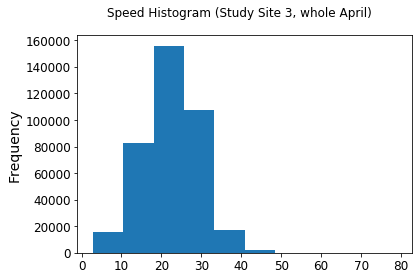

In [ ]:
# plot some histograms of the data
study_site_3['SPEED'].plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Speed Histogram (Study Site 3, whole April)')

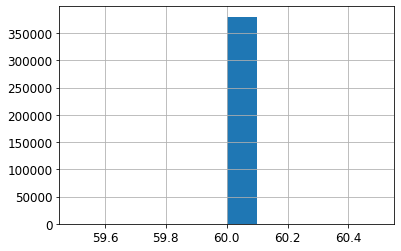

In [ ]:
study_site_3['SPEEDLIMIT'].hist()

In [ ]:
study_site_3['SPEEDLIMIT'].unique()

array([60.])

In [ ]:
def retrieve_meta_data_df(study_site):
#  if study_site in ['StudySite1', 'StudySite2']:
#    filename = "Highway_Speed_5Min.csv"
#  elif study_site in ['StudySite3']:
#    filename = "GangNamGu_Speed_5Min.csv"
#  elif study_site in ['StudySite4']:
  filename = "speed_limit_info.csv"

  # Store dataset in a Pandas Dataframe
  path = F"{sttf_folder}/Raw_Data/{filename}"
  #return pd.read_csv(path, encoding='cp1252')
  return pd.read_csv(path)

# extract the speedlimit given an order of link ids and a study site number
def extract_speed_limit(study_site, order):
  df = retrieve_meta_data_df(study_site)

  # names of columns
  #col_linkid      = 'LINKID'
  #col_speedlimit  = 'SPEEDLIMIT'
  col_linkid      = 'LINK_ID'
  col_speedlimit  = 'speedLimit'

  # get all the link ids included in study site
  df = df[df[col_linkid].isin(order)]

  # drop duplicates
  df = df.drop_duplicates(subset=col_linkid)

  # reorder them and return the speedlimit as a pandas series, as well as max times 1.5
  df = df.set_index(col_linkid)
  df = df.reindex(order)
  return df[col_speedlimit], df[col_speedlimit].max() * 1.5

# calculate the density normalized values in a df based on the speed limit panda series
def density_normalize_data(df, min_speed, max_speed, speed_limit):
  # clip the values first between min_speed and max_speed
  df = df.clip(min_speed, max_speed)
  df = df.div(speed_limit, axis=0)
  return df

def density_denormalize_data(arr, speed_limit):
  return arr * speed_limit

In [ ]:
# show that the density normalization is working
speed_limit, max_speed = extract_speed_limit('StudySite3', all_link_ids)
print(type(speed_limit))
normalized_data = density_normalize_data(df, 0, 120, speed_limit)
normalized_data

<class 'pandas.core.series.Series'>


,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,...,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289
V1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1220028100,0.284667,0.324833,0.356167,0.296667,0.270000,0.279333,0.272333,0.272833,0.268000,0.338667,0.295333,0.286667,0.294167,0.302833,0.305833,0.302667,0.283167,0.325333,0.303667,0.289333,0.401500,0.379500,0.302333,0.344500,0.295833,0.332667,0.298167,0.279833,0.303333,0.294000,0.341167,0.294000,0.304667,0.330167,0.378833,0.347500,0.296000,0.346333,0.332333,0.446167,...,0.243833,0.181000,0.228167,0.186167,0.244000,0.173833,0.199833,0.217333,0.227333,0.190167,0.225000,0.239667,0.252000,0.250667,0.267167,0.245000,0.291333,0.282000,0.219333,0.248667,0.236167,0.230667,0.232833,0.200167,0.185333,0.178667,0.234000,0.319667,0.334167,0.402333,0.355500,0.275333,0.305500,0.290833,0.277667,0.288833,0.289167,0.296667,0.275000,0.302500
1220022900,0.452500,0.458333,0.402667,0.396833,0.459833,0.443833,0.426333,0.446500,0.472667,0.435833,0.462333,0.405333,0.442833,0.414333,0.496167,0.421500,0.454500,0.453667,0.470667,0.431833,0.410500,0.441833,0.452833,0.549333,0.434333,0.513167,0.537500,0.414167,0.452667,0.437000,0.476167,0.474000,0.417167,0.457833,0.415333,0.473500,0.568167,0.437167,0.433333,0.433667,...,0.310333,0.339500,0.279833,0.267167,0.325167,0.323500,0.319167,0.343000,0.282500,0.337500,0.309333,0.362167,0.301167,0.368667,0.399500,0.336500,0.342667,0.420333,0.391167,0.341000,0.467333,0.421500,0.442167,0.424500,0.413833,0.397333,0.436500,0.418667,0.421000,0.424000,0.400500,0.440167,0.397333,0.436000,0.409167,0.425167,0.470333,0.477833,0.494167,0.420333
1220023000,0.579667,0.582000,0.601667,0.523500,0.512167,0.443500,0.520167,0.452000,0.595000,0.436667,0.469000,0.448500,0.422500,0.472167,0.353667,0.405500,0.489167,0.513667,0.470000,0.594000,0.640000,0.506500,0.469667,0.592500,0.487500,0.632333,0.553167,0.488500,0.554833,0.616833,0.609000,0.509333,0.527167,0.513833,0.502167,0.507333,0.563833,0.416667,0.501500,0.596000,...,0.362000,0.338333,0.362000,0.378167,0.344333,0.357000,0.484167,0.345833,0.399000,0.354167,0.357667,0.401833,0.376833,0.348167,0.358833,0.365500,0.370833,0.398500,0.355500,0.378000,0.366333,0.324667,0.351167,0.370500,0.360500,0.299500,0.377667,0.348833,0.346833,0.343667,0.352000,0.352167,0.369000,0.368167,0.377000,0.372333,0.353000,0.379833,0.356667,0.413167
1220026300,0.588000,0.529167,0.565833,0.447667,0.539000,0.528833,0.465500,0.496167,0.466667,0.426667,0.484500,0.453667,0.446667,0.517167,0.385833,0.466000,0.556333,0.545167,0.484167,0.573000,0.580167,0.529167,0.527833,0.541500,0.598833,0.554500,0.559500,0.531167,0.548000,0.574667,0.484500,0.579333,0.497167,0.547167,0.486167,0.462167,0.505333,0.578000,0.537000,0.617833,...,0.278667,0.425000,0.337500,0.312333,0.272333,0.331667,0.425333,0.258833,0.307667,0.382833,0.334167,0.396000,0.329500,0.366000,0.402000,0.369667,0.411000,0.432167,0.453333,0.466333,0.443000,0.427500,0.489333,0.456833,0.462500,0.420000,0.462167,0.493333,0.504000,0.446667,0.434000,0.460167,0.432000,0.420667,0.395500,0.482000,0.489333,0.490333,0.432167,0.447500
1220030800,0.552000,0.507000,0.473000,0.467833,0.440333,0.444333,0.399333,0.504667,0.432000,0.412833,0.533333,0.452000,0.439667,0.480500,0.430667,0.528000,0.502500,0.449667,0.473833,0.410000,0.511667,0.533000,0.416167,0.539000,0.541667,0.532167,0.598833,0.660500,0.467000,0.486333,0.577000,0.547833,0.725000,0.666667,0.700000,0.483167,0.514833,0.591667,0.541833,0.525667,...,0.306833,0.381000,0.305333,0.321167,0.319167,0.326333,0.317667,0.328500,0.296833,0.254500,0.319833,0.345000,0.268833,0.343833,0.353833,0.400000,0.300500,0.441667,0.347000,0.425667,0.344667,0.314833,0.371833,0.466833,0.434667,0.450333,0.346667,0

## Data Preparation

In [ ]:
# function to extract a training step from the data:
def prepare_training_step(df, start_index, number_past_timesteps, number_future_timesteps):
  boundary = start_index + number_past_timesteps
  # data should not exceed bounds
  if (boundary + number_future_timesteps) > df.shape[1]:
    return None
  # select all rows, columns between bounds as x
  x = df.iloc[:, start_index:boundary]
  # and number of future timesteps as y
  y = df.iloc[:, boundary:(boundary + number_future_timesteps)]
  x = x.to_numpy()
  y = y.to_numpy()
  if CNN: # add the channels dimension as channels last
    x = np.expand_dims(x, axis=2)
  return x, y

def retrieve_train_data(df, number_past_timesteps, number_future_timesteps):
  last_iteration_index = df.shape[1] - number_future_timesteps - number_past_timesteps
  x, y = [], []
  for i in range(last_iteration_index + 1):
    x_data, y_data = prepare_training_step(df, i, number_past_timesteps, number_future_timesteps)
    x.append(x_data)

    # transpose and flatten the y_data, considering the output shape of the model
    y_data = y_data.transpose().flatten()

    y.append(y_data)    
  return np.array(x), np.array(y)

def prepare_training_step_with_offset(df, start_index, number_past_timesteps, number_future_timesteps, time_offset):
  boundary = start_index + number_past_timesteps
  # data should not exceed bounds
  if (boundary + number_future_timesteps + time_offset) > df.shape[1]:
    return None
  # select all rows, columns between bounds as x
  x = df.iloc[:, start_index:boundary]
  # and number of future timesteps as y
  y = df.iloc[:, (boundary + time_offset):(boundary + number_future_timesteps + time_offset)]
  x = x.to_numpy()
  y = y.to_numpy()
  if CNN: # add the channels dimension as channels last
    x = np.expand_dims(x, axis=2)
  return x, y

def retrieve_train_data_with_offset(df, number_past_timesteps, number_future_timesteps, time_offset):
  last_iteration_index = df.shape[1] - number_future_timesteps - number_past_timesteps - time_offset
  x, y = [], []
  for i in range(last_iteration_index + 1):
    x_data, y_data = prepare_training_step_with_offset(df, i, number_past_timesteps, number_future_timesteps, time_offset)
    x.append(x_data)

    # transpose and flatten the y_data, considering the output shape of the model
    y_data = y_data.transpose().flatten()

    y.append(y_data)    
  return np.array(x), np.array(y)

In [ ]:
# let's specify two different orderings for the link ids for study site 3
study_site_3_order_link_ids_random = [1220026200, 1220022900, 1220023000, 1220026300, 1220030800, 1220030000, 1220029000, 1220028200, 1220028300, 1220029100, 1220030100, 1220030900, 1220029200, 1220026600, 1220026700, 
                1220029300, 1220027600, 1220025800, 1220025900, 1220027700, 1220027400, 1220024600, 1220024700, 1220027500, 1220022300, 1220023900, 1220025500, 1220026500, 1220026400, 1220025400, 
                1220023800, 1220022200, 1220003300, 1220003100, 1220003200, 1220003400, 1220028000, 1220026800, 1220026000, 1220025200, 1220025300, 1220026100, 1220026900, 1220028100]
study_site_3_order_link_ids_outside_first = [1220030800, 1220030000, 1220029000, 1220028200, 1220026200, 1220022900, 1220022300, 1220023900, 1220025500, 1220026500, 1220003200, 1220003400, 1220003300, 1220003100, 
                                1220026400, 1220025400, 1220023800 , 1220022200, 1220023000, 1220026300, 1220028300, 1220029100, 1220030100, 1220030900, 1220028000, 1220026800, 1220026000, 1220025200, 1220025300, 
                                1220026100, 1220026900, 1220028100, 1220029200, 1220026600, 1220026700, 1220029300, 1220027600, 1220025800, 1220025900, 1220027700, 1220027400, 1220024600, 1220024700, 1220027500]

# and also specify two different orderings for the link ids for study site 4
study_site_4_order_link_ids_outside_first = [1020001600, 1030001200, 1030000900, 1220037200, 1220036800, 1220036000, 1220035000, 1210006300, 1210030700, 1210030600, 1210006200, 1220035100, 1220036100, 1220036900, 1220037300,
       1030001000, 1030001100, 1020000900, 1210006500, 1220005700, 1220005600, 1210006400, 1220037000, 1220036600, 1220036700, 1220037100]
study_site_4_order_link_ids_random = [1210006400, 1220037200, 1210030600, 1210006200, 1220036800, 1220036100, 1220037100, 1030001200, 1220005700, 1020001600, 1210006300, 1220037000, 1030001100, 1210030700, 1210006500,
       1220035100, 1030001000, 1020000900, 1220036700, 1220037300, 1030000900, 1220035000, 1220036900, 1220036000, 1220036600, 1220005600]
study_site_4_order_link_ids_highway_first = [1210030600, 1210006500, 1220005700, 1220037300, 1030001000, 1030001100, 1020000900, 1020001600, 1030001200, 1030000900, 1220037200, 1220005600, 1210006400, 1210030700, 1220037000, 
                                             1220036600, 1220036700, 1220037100, 1210006200, 1220035100, 1220036100, 1220036900, 1220036800, 1220036000, 1220035000, 1210006300]

In [ ]:
assert len(set(study_site_3_order_link_ids_outside_first)) == len(set(study_site_3_order_link_ids_random))
assert len(set(study_site_4_order_link_ids_outside_first)) == len(set(study_site_4_order_link_ids_random)) == len(set(study_site_4_order_link_ids_highway_first))

In [ ]:
# let's take the first few datasets as training data and the next few ones as validation data
train_files     = [2,3,4,5,6,9,10,11,12,13,16,17,23,24,25]
val_files       = [18,19,20]
test_files      = [26,27,30]
study_site      = "StudySite4"
month           = 4
order_link_ids  = study_site_4_order_link_ids_highway_first
CNN             = False # set this variable to false to ignore channels

# hyperparams
if order_link_ids is not None:
  number_link_ids     = len(order_link_ids)
else:
  number_link_ids   = 10      # only define it if it cannot be inferred
past_time_steps     = 12
number_channels     = 1       # if number_channels > 1, then density is used as additional channel
data_representation = 'speed' # which representation to use, can be 'speed', 'color' or 'density'
task                = 1       # task should either be 1, 2 or 3 
min_speed           = 0
#speed_limit         = 80     # speed_limit is only necessary for density representation and will be inferred from the data set

# based on the different tasks, calculate the relevant hyperparams
# for task two, this variable should be set to 6, else it should be None
if task == 1:
  future_time_steps   = 3
  offset              = None
if task == 2:
  future_time_steps   = 1
  offset              = 6
if task == 3:
  print("Task 3 not implemented yet.")

# for the different representations, other hyperparameter will be set
if data_representation == 'color':
  value_for_min_speed = 255

# shape of x is dependant on whether or not this is a CNN approach
if CNN:
  shape_x = [0, number_link_ids, past_time_steps, number_channels]
else:
  shape_x = [0, number_link_ids, past_time_steps]

shape_y = [0, number_link_ids * future_time_steps]

def concat_input_files(file_list, shape_x, shape_y):
  x, y = np.empty(shape_x), np.empty(shape_y)
  for f in file_list:
    path = F"{sttf_folder}/Input Data/{study_site}/{study_site}_{month}{f}.csv"

    if study_site in ['StudySite1', 'StudySite2']:
      df = pd.read_csv(path, index_col=0)
    else:
      df = pd.read_csv(path, index_col=1)
      # remove unnamed column from the df
      df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # if an order of the link ids is supplied, rearrange the df 
    # and get the speed limits for the given order
    if order_link_ids is not None:
      sort_dict = get_sort_dict(order_link_ids)
      df = sort_by_linkid(df, sort_dict)
      speed_limit, max_speed = extract_speed_limit(study_site, order_link_ids)
    else:
      max_speed = 120 # always clip values above 120 km/h

    # convert the data into the chosen data representation
    if data_representation == 'color': 
      df = color_normalize_data(df, min_speed, max_speed, value_for_min_speed)
    elif data_representation == 'speed':   
      # clip the values between min_speed and max_speed
      df = df.clip(min_speed, max_speed)
    elif data_representation == 'density':
      df = density_normalize_data(df, min_speed, max_speed, speed_limit)

    if offset is None:
      x_data, y_data = retrieve_train_data(df, past_time_steps, future_time_steps)
    else:
      x_data, y_data = retrieve_train_data_with_offset(df, past_time_steps, future_time_steps, offset)

    # if number_channels > 1, then density is used as additional channel
    if number_channels > 1:
      density_data = density_normalize_data(df, min_speed, max_speed, speed_limit)
      if offset is None:
        x_data_density, _ = retrieve_train_data(density_data, past_time_steps, future_time_steps)
      else:
        x_data_density, _ = retrieve_train_data_with_offset(density_data, past_time_steps, future_time_steps, offset)

      x_data = np.concatenate([x_data, x_data_density], axis=3)

    x = np.append(x, x_data, axis=0)
    y = np.append(y, y_data, axis=0)
  return x, y
  
x_train, y_train = concat_input_files(train_files, shape_x, shape_y)
x_val, y_val     = concat_input_files(val_files, shape_x, shape_y)
x_test, y_test   = concat_input_files(test_files, shape_x, shape_y)

if not CNN:
  # reshape input to be [samples, time steps, features] instead of [samples, time steps, features]
  x_train = np.swapaxes(x_train,1,2)
  x_val   = np.swapaxes(x_val,  1,2)
  x_test  = np.swapaxes(x_test, 1,2)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(4110, 12, 26)
(4110, 78)
(822, 12, 26)
(822, 78)
(822, 12, 26)
(822, 78)


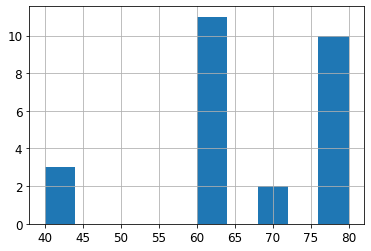

In [ ]:
# proof that the speed limits for study site 4 differ
speed_limit, max_speed = extract_speed_limit('StudySite4', study_site_4_order_link_ids_outside_first)
speed_limit.hist()

In [ ]:
# print out the raw data of one training example
x_train[0]

array([[ 59.1 ,  90.  ,  87.  ,  64.26,  93.  ,  93.  ,  96.  ,  90.  ,
         88.  ,  91.  ,  55.62,  83.  ,  69.  ,  62.62,  58.49,  34.56,
         54.77,  54.4 ,  50.06,  25.18,  30.58,  48.12,  33.94,  32.81,
         29.14,  52.73],
       [ 64.94,  90.  ,  85.  ,  62.43,  90.  ,  90.  ,  92.  ,  86.  ,
         86.  ,  94.  ,  56.73,  88.  ,  80.  ,  63.73,  51.84,  52.05,
         54.46,  54.03,  50.74,  28.8 ,  27.11,  48.99,  31.16,  32.93,
         34.11,  51.37],
       [ 62.94,  85.  ,  81.  ,  61.81,  96.  ,  96.  , 101.  ,  83.  ,
         89.  ,  95.  ,  57.42,  82.  ,  84.  ,  63.32,  59.68,  46.7 ,
         50.14,  59.12,  50.72,  22.35,  26.73,  48.87,  33.98,  25.65,
         26.31,  52.91],
       [ 61.32,  88.  ,  89.  ,  64.41,  95.  ,  95.  ,  90.  ,  87.  ,
         88.  ,  91.  ,  56.24,  90.  ,  80.  ,  62.26,  57.31,  37.72,
         55.52,  58.57,  50.54,  23.85,  25.56,  47.96,  34.98,  31.23,
         29.1 ,  53.46],
       [ 63.16,  91.  ,  85.  ,  62.

# Model Creation

**Taken from the paper:**

The details of the depth-4 CNN are listed in Table 2. The model input has three dimensions (1,
236, 20), where the first number indicates that the input image has one channel, the second number
represents the total number of road sections in Network 1, and the third number refers to the input
time span, which is 20 time units. Convolutional layers consecutively transform the number of
channels into 256, 128, and 64 with the corresponding quantity of convolutional filters, respectively.
At the same time, pooling layers consecutively downsample the input window to (118, 10), (59, 5),
and (30, 3). The output dimensions in layer 6 are (64, 30, 3), which are then flattened into a vector
with a dimension of 5760. The vector is finally transformed into the model output with a dimension
of 1180 through a fully-connected layer.

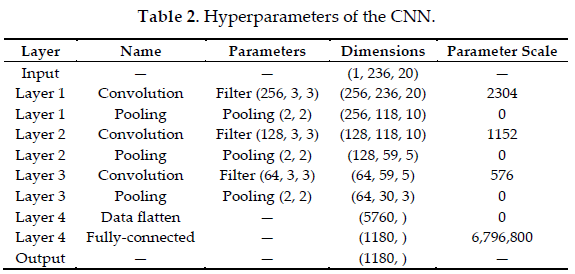

**The statement taken from the paper above can be transformed into our own architecture like so:**

* Input Shape: (1, 10, 12) -> 1 channel, 10 link IDs, 12 time steps (12 * 5 min = 60 min)
* Output Shape: (10, 2) -> we have 10 link IDs to predict the next 10 minutes for in 5 min intervals -> **Question: or should we only have (10,) as output shape and only predict the average of the next 10 mins as one value per linkid?**

In the paper, the authors were consecutively downsizing the number of filters. This is strange, as normally the amount of filters will increase (at least afaik) in deeper layers. Also, I added some Dropout layers between the fully connected dense layers in order to let the model generalize better.

The amount of Pooling Layers is too high for such a small image to learn from.


In [ ]:
from functools import partial

# hyperparameters:
activation_function_dense = 'relu'
padding                   = "SAME"
loss                      = "mean_squared_logarithmic_error"
optimizer                 = "nadam"
kernel_size               = 3
dropout_rate              = 0.2
output_shape              = number_link_ids * future_time_steps
input_shape               = [past_time_steps, number_link_ids] # = x_train.shape[1:]
model_name                = "study_site_4_task_1_LSTM_remove_lstm_layer"

model = keras.models.Sequential()

model.add(keras.layers.LSTM(units=number_link_ids, return_sequences = False, input_shape=input_shape))
#model.add(keras.layers.LSTM(units=number_link_ids, activation='relu'))
model.add(keras.layers.Dense(100))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(units=output_shape, activation='linear'))

model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 26)                5512      
_________________________________________________________________
dense (Dense)                (None, 100)               2700      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 78)                7878      
Total params: 16,090
Trainable params: 16,090
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# for consistency
np.random.seed(42)

# where to save the model
model_save_name = F"{model_name}.h5"
model_save_path = F"{sttf_folder}/Jupyter Notebooks/models/{model_save_name}" 

# introduce early stopping to prevent the model from overfitting and save the best model by checkpointing
callback_checkpoint     = keras.callbacks.ModelCheckpoint(model_save_path, save_best_only=True)
callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train, epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=[callback_checkpoint, callback_early_stopping])

Train on 4110 samples, validate on 822 samples
Epoch 1/50
4110/4110 [==============================] - 8s 2ms/sample - loss: 4.4568 - accuracy: 0.0314 - val_loss: 1.3013 - val_accuracy: 0.0000e+00
Epoch 2/50
4110/4110 [==============================] - 1s 282us/sample - loss: 0.9025 - accuracy: 0.1010 - val_loss: 0.7095 - val_accuracy: 0.2007
Epoch 3/50
4110/4110 [==============================] - 1s 308us/sample - loss: 0.6235 - accuracy: 0.1470 - val_loss: 0.5845 - val_accuracy: 0.2007
Epoch 4/50
4110/4110 [==============================] - 1s 307us/sample - loss: 0.5342 - accuracy: 0.1560 - val_loss: 0.3497 - val_accuracy: 0.2007
Epoch 5/50
4110/4110 [==============================] - 1s 318us/sample - loss: 0.3287 - accuracy: 0.1440 - val_loss: 0.3115 - val_accuracy: 0.2007
Epoch 6/50
4110/4110 [==============================] - 1s 307us/sample - loss: 0.3060 - accuracy: 0.1418 - val_loss: 0.2977 - val_accuracy: 0.2007
Epoch 7/50
4110/4110 [==============================] - 1s 320u

Saving figure study_site_4_task_1_LSTM_remove_lstm_layer_learning_curve


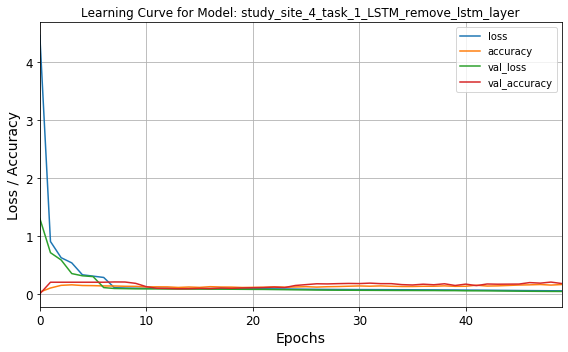

In [ ]:
learning_curve(history, model_name, save=True)

# Example of how the model will learn

In [ ]:
# which example index should we take?
index = 200
output_shape = (number_link_ids, future_time_steps)

Saving figure study_site_4_task_1_LSTM_remove_lstm_layer_Test_Input


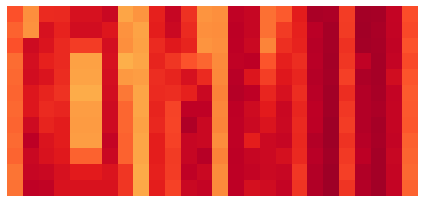

In [ ]:
# This will be the input of one test example
if number_channels == 1:
  if CNN:
    x_image = np.reshape(x_test[index], x_test[index].shape[:-1])
  else:
    x_image = x_test[index]
else:
  helper_image = x_test[index]
  helper_image = np.delete(helper_image, 1, axis=2) # remove second channel from image
  x_image = np.reshape(helper_image, x_test[index].shape[:-1])
plot_image(x_image, model_name + "_Test_Input", save=True)

In [ ]:
# for plotting, we need to put the speed values for the link ids next to each other
# therefore, we rearange the numpy array like this:
def reshape_output(arr, shape):
  return arr.reshape(shape, order="F")

Saving figure study_site_4_task_1_LSTM_remove_lstm_layer_Test_True


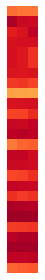

In [ ]:
# and this will be the true label of one test example
y_image = np.reshape(y_test[index], [y_test[index].shape[-1],1])
y_image = reshape_output(y_image, output_shape)
plot_image(y_image, model_name + "_Test_True", save=True)

[[39.177067  38.63373   39.09337  ]
 [14.316712  14.125077  13.930972 ]
 [16.924982  17.411493  17.44222  ]
 [17.381966  16.945726  16.33471  ]
 [50.157436  50.743317  49.832493 ]
 [48.19103   49.298912  49.635887 ]
 [26.044298  27.055286  27.143383 ]
 [30.762535  30.61961   30.26206  ]
 [50.862904  51.04707   50.83841  ]
 [26.92873   26.686352  27.095598 ]
 [32.45552   32.4238    32.2555   ]
 [21.66745   22.490967  22.906708 ]
 [13.935985  14.626429  14.969508 ]
 [45.24373   46.24216   45.71303  ]
 [20.701908  20.746105  20.834358 ]
 [20.04908   20.26903   20.442259 ]
 [31.645182  30.720652  30.54694  ]
 [25.36515   25.004313  24.714685 ]
 [30.123714  30.387861  29.89307  ]
 [ 8.432917   8.56616    8.612514 ]
 [ 7.033655   6.9459105  6.9321895]
 [29.889214  29.59265   29.375183 ]
 [11.245677  11.460894  11.426906 ]
 [ 8.134197   8.223823   8.482869 ]
 [14.572298  14.576017  14.566145 ]
 [37.36389   37.005005  36.844044 ]]
Saving figure study_site_4_task_1_LSTM_remove_lstm_layerTest_Pr

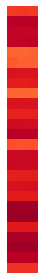

In [ ]:
# let's let the model predict from the first test example
y_pred = model.predict(np.expand_dims(x_test[index], 0))
y_pred = np.reshape(y_pred, [y_pred.shape[-1],1])
y_pred = reshape_output(y_pred, output_shape)
print(y_pred)
plot_image(y_pred, model_name + "Test_Pred", save=True)

# Test Set Evaluation

In [ ]:
model = tf.keras.models.load_model(model_save_path)
test_loss, test_accuracy = model.evaluate(x_test, y_test)

822/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
print(test_loss)
print(test_accuracy)

0.04738267526991321
0.14963503


# Create Evaluation Graphs

In [ ]:
# linkid to select the graph for is 7, so it's index is 7 - 1
if study_site == 'StudySite3':
  # find index with linkid 1220028000 in order
  linkid_raw = 1220028000
  linkid = order_link_ids.index(linkid_raw)
elif study_site == 'StudySite4':
  # find index with linkid 1220037100 in order, because it's one of the bridges
  linkid_raw = 1220037100
  linkid = order_link_ids.index(linkid_raw)
else:
  linkid_raw = 7
  linkid = 7 - 1
indices = [linkid + number_link_ids * i for i in range(future_time_steps)]
indices

[17, 43, 69]

In [ ]:
from sklearn.metrics import mean_squared_error

# collect the predictions on the test set
y_pred = model.predict(x_test)

# convert the data into the chosen data representation
if data_representation == 'color': 
  y_pred = color_denormalize_data(y_pred, max_speed, max_color_value=255)
  y_test = color_denormalize_data(y_test, max_speed, max_color_value=255)

five_min_preds, ten_min_preds, fifteen_min_preds = [], [], []
five_min_trues, ten_min_trues, fifteen_min_trues = [], [], []

for i in range(len(y_pred)):
  five_min_preds.append(y_pred[i][indices[0]])
  five_min_trues.append(y_test[i][indices[0]])

  if future_time_steps > 1:
    ten_min_preds.append(y_pred[i][indices[1]])
    ten_min_trues.append(y_test[i][indices[1]])

  if future_time_steps > 2:
    fifteen_min_preds.append(y_pred[i][indices[2]])
    fifteen_min_trues.append(y_test[i][indices[2]])


# specify a time range
#table['TIME'] = pd.DataFrame(columns=['NULL'],
#                index=pd.date_range('2018-04-23T01:00:00Z', '2018-04-23T23:55:00Z',
#                                    freq='5T')).between_time('01:00','23:55').index.strftime('%Y-%m-%dT%H:%M:%SZ')
#table.head()

In [ ]:
# create the MSLE plot:
def msle_plot(df, name, save):
  df.plot(x='TIME', figsize=(8, 5))
  plt.grid(True)
  #plt.gca().set_ylim(0, 1)
  plt.gca()
  if save:
    save_fig(name + "rmse_plot")
  plt.show()

In [ ]:
#msle_plot(table, model_name, save=True)

In [ ]:
#pd.DataFrame(y_pred).to_csv(F"{sttf_folder}/Output Data/StudySite4/order_random_y_pred.csv", index=False)
#pd.DataFrame(y_test).to_csv(F"{sttf_folder}/Output Data/StudySite4/order_random_y_test.csv", index=False)

In [ ]:
def true_pred_comparison(df, name, time, save=False):
  # data representation changes what's being expressed in the graph
  if data_representation in ['color', 'speed']: 
    label = "Min average Speed in km/h"
  elif data_representation == 'density':   
    label = "Density values"

  fig = df.plot(figsize=(8, 5))
  plt.grid(True)
  fig.set_title(F"True/Pred Test Set Comparison, LinkID: {linkid_raw}")
  plt.xlabel(F"Prediction Time Index (span: {len(test_files)} days)")
  plt.ylabel(F"{time} {label}")
  plt.gca()
  if save:
    save_fig(F"{name}_{time}_min_true_pred_comparison")
  plt.show()

Saving figure study_site_4_task_1_LSTM_remove_lstm_layer_5_min_true_pred_comparison


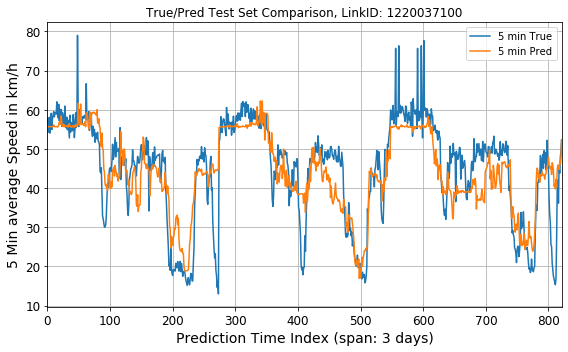

Saving figure study_site_4_task_1_LSTM_remove_lstm_layer_10_min_true_pred_comparison


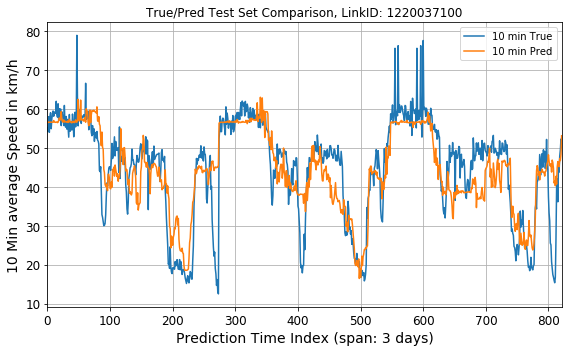

Saving figure study_site_4_task_1_LSTM_remove_lstm_layer_15_min_true_pred_comparison


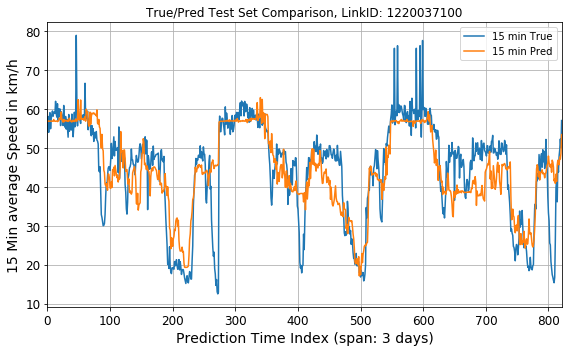

In [ ]:
five_mins = {'5 min True':five_min_trues,'5 min Pred':five_min_preds}
five_mins = pd.DataFrame(five_mins)
true_pred_comparison(five_mins, model_name, "5", save=True)

# save the variables with labels
bars = [five_mins]
labels = ['5 Min']

if future_time_steps > 1:
  ten_mins = {'10 min True':ten_min_trues,'10 min Pred':ten_min_preds}
  ten_mins = pd.DataFrame(ten_mins)
  true_pred_comparison(ten_mins, model_name, "10", save=True)
  bars.append(ten_mins)
  labels.append('10 Min')

if future_time_steps > 2:
  fifteen_mins = {'15 min True':fifteen_min_trues,'15 min Pred':fifteen_min_preds}
  fifteen_mins = pd.DataFrame(fifteen_mins)
  true_pred_comparison(fifteen_mins, model_name, "15", save=True)
  bars.append(fifteen_mins)
  labels.append('15 Min')

In [ ]:
def get_MAPE_value(df):
  absolute_errors = []
  for i in range(len(df)):
    true = df.iloc[i,0]
    pred = df.iloc[i,1]
    error = abs((true-pred)/true)
    absolute_errors.append(error)
  assert len(absolute_errors) == len(df)
  return sum(absolute_errors)/len(df) * 100

In [ ]:
def MAPE(pred_array, true_array):
  assert pred_array.shape == true_array.shape
  absolute_errors = np.abs((np.subtract(true_array, pred_array)) / true_array)
  return absolute_errors.sum() / (true_array.shape[0] * true_array.shape[1]) * 100

# this function computes MAPE values for all link ids for all bars
def compute_MAPE_values():
  shape = (number_link_ids, len(y_pred))
  five_min_preds, ten_min_preds, fifteen_min_preds = np.zeros(shape), np.zeros(shape), np.zeros(shape)
  five_min_trues, ten_min_trues, fifteen_min_trues = np.zeros(shape), np.zeros(shape), np.zeros(shape)

  for link_idx in range(number_link_ids):
    # get current index
    indices = [link_idx + number_link_ids * j for j in range(future_time_steps)]
    
    for i in range(len(y_pred)):
      five_min_preds[link_idx][i] = y_pred[i][indices[0]]
      five_min_trues[link_idx][i] = y_test[i][indices[0]]

      if future_time_steps > 1:
        ten_min_preds[link_idx][i] = y_pred[i][indices[1]]
        ten_min_trues[link_idx][i] = y_test[i][indices[1]]

      if future_time_steps > 2:
        fifteen_min_preds[link_idx][i] = y_pred[i][indices[2]]
        fifteen_min_trues[link_idx][i] = y_test[i][indices[2]]

  five_min_MAPE     = MAPE(five_min_preds, five_min_trues)
  ten_min_MAPE      = MAPE(ten_min_preds, ten_min_trues)
  fifteen_min_MAPE  = MAPE(fifteen_min_preds, fifteen_min_trues)

  return five_min_MAPE, ten_min_MAPE, fifteen_min_MAPE

five_min_MAPE, ten_min_MAPE, fifteen_min_MAPE = compute_MAPE_values()

In [ ]:
def plot_MAPE_bar_chart(MAPE_values, labels, name, save=False, ylim=30):
  x = np.arange(len(labels))  # the label locations
  width = 0.5  # the width of the bars

  fig, ax = plt.subplots(figsize=(8,5))
  rects1 = ax.bar(x, MAPE_values, width, label=name)

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('MAPE')
  ax.set_xlabel('Prediction Time Offset')
  ax.set_title(F"MAPE values per Prediction Time Offset on Test Set for Model: {name}")
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(), 2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

  autolabel(rects1)
  
  plt.gca().set_ylim(0, ylim)
  fig.tight_layout()
  plt.gca()
  if save:
    save_fig(name + "_MAPE_comparison")
  plt.show()

In [ ]:
#def plot_MAPE_bar_chart(mape_df):
#  mape_df.plot.bar(x='Prediction Time Offset', y='MAPE', rot=0)
#  save_fig(model_name + "_MAPE_comparison")

[16.157940649749982, 16.340935315437005, 16.584979772360654]
Saving figure study_site_4_task_1_LSTM_remove_lstm_layer_MAPE_comparison


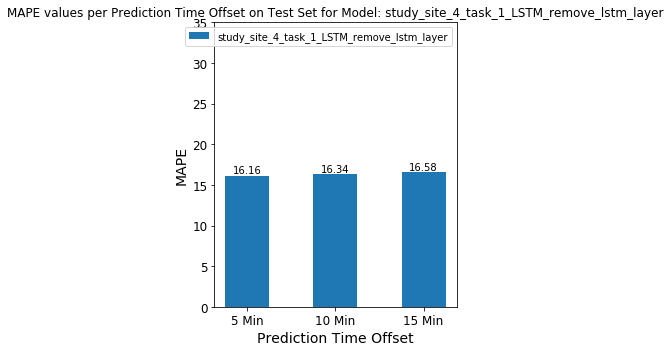

In [ ]:
MAPE_values = [five_min_MAPE]
if future_time_steps > 1:
  MAPE_values.append(ten_min_MAPE)
if future_time_steps > 2:
  MAPE_values.append(fifteen_min_MAPE)

print(MAPE_values)
plot_MAPE_bar_chart(MAPE_values, labels, model_name, save=True, ylim=35)